## Importing libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
sns.set()

import warnings
warnings.filterwarnings('ignore') # to ignore warnings during ML deployment

## Importing and preprocessing

In [3]:
data = pd.read_csv('Obesity prediction.csv')
data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
data.info()# to see data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

In [29]:
# In order to create a model later I will need to indentify all columns with categorical features and change them to numerical later
categorical = []
for col in data.columns:
    if data[col].dtypes == object:
        categorical.append(col)

for i in categorical:
    print(data[i].value_counts())
    print('-'*50)

Gender
Male      1068
Female    1043
Name: count, dtype: int64
--------------------------------------------------
family_history
yes    1726
no      385
Name: count, dtype: int64
--------------------------------------------------
FAVC
yes    1866
no      245
Name: count, dtype: int64
--------------------------------------------------
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64
--------------------------------------------------
SMOKE
no     2067
yes      44
Name: count, dtype: int64
--------------------------------------------------
SCC
no     2015
yes      96
Name: count, dtype: int64
--------------------------------------------------
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64
--------------------------------------------------
MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike     

## Plotting the data

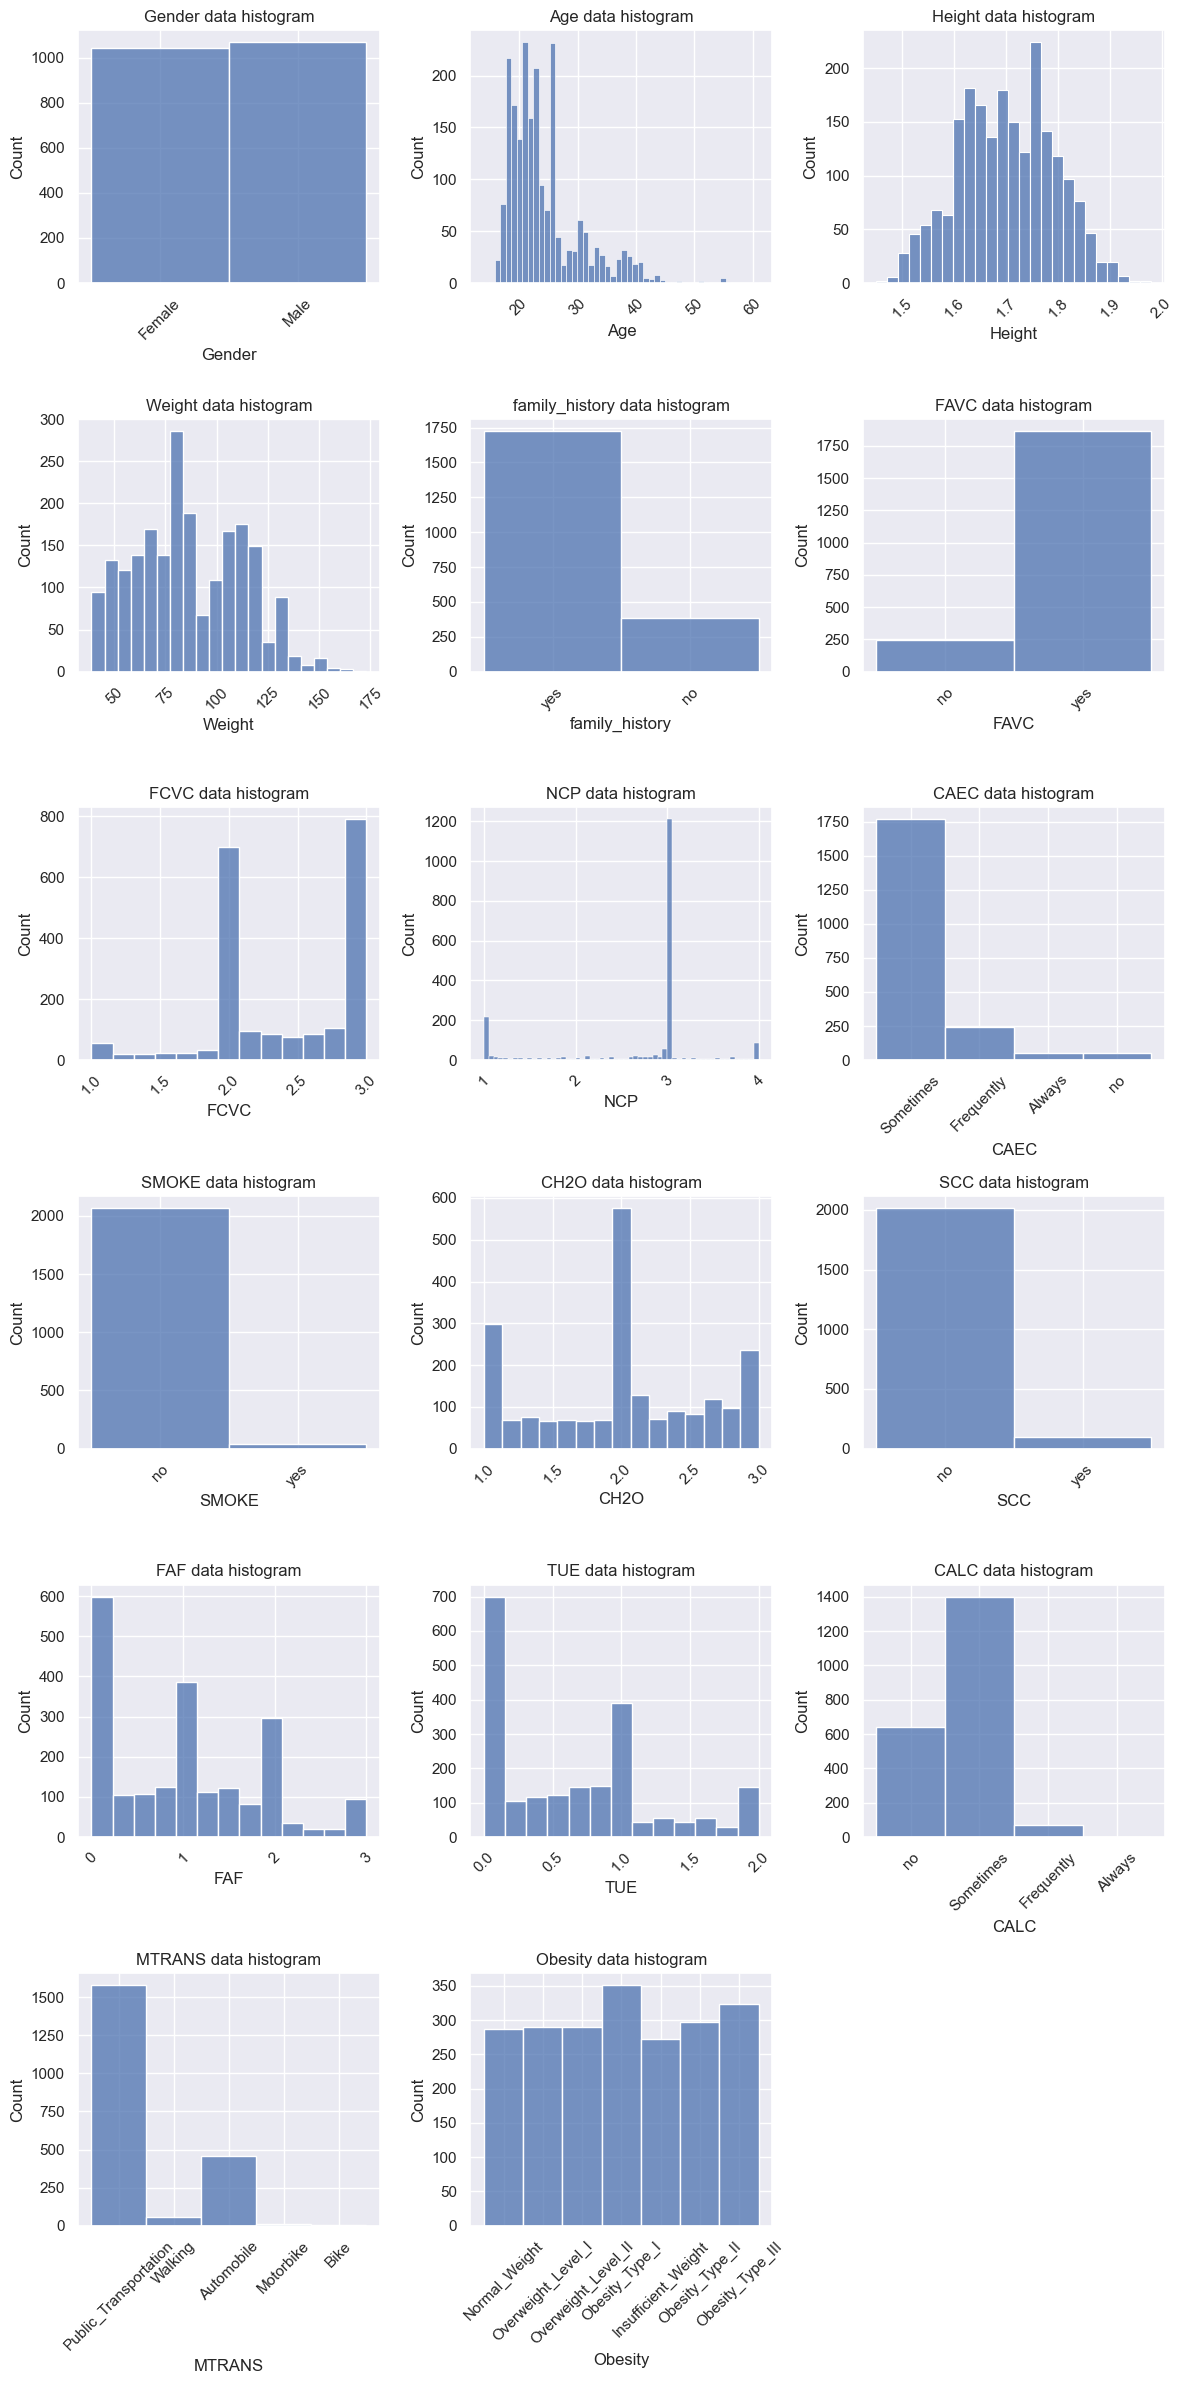

In [8]:
plt.figure(figsize = (12,24))
for i, col in enumerate(data.columns, 1): # for every column, show histogram
    plt.subplot(6, 3, i)
    sns.histplot(x = data[col])
    plt.title(f'{col} data histogram')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.plot()

<Axes: xlabel='Obesity'>

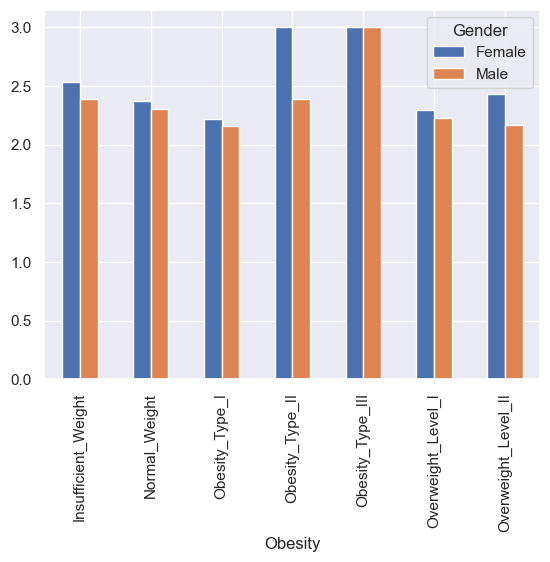

In [23]:
# FCVC is the number of meals in which one eats vegetables
# Below is the pivot by gender and obesity level showcasing an average FCVC score
fcvc = data.pivot_table(index='Obesity', columns='Gender', values='FCVC', aggfunc='mean')
fcvc.plot.bar()

# Looks like regardless of obesity level, women tend eat more vegetables than men

<Axes: xlabel='Obesity'>

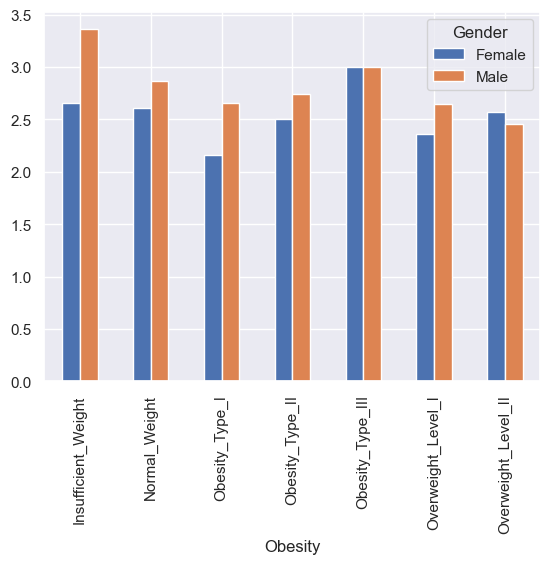

In [25]:
# NCP is the number of main meals per day
# Below is the pivot by gender and obesity level showcasing an average NCP score
fcvc = data.pivot_table(index='Obesity', columns='Gender', values='NCP', aggfunc='mean')
fcvc.plot.bar()

# Looks like regardless of obesity level, men tend to eat more main meals a day than women
# Females tend to eat more main meals a day on average than men in the highest obesity level 

<Axes: xlabel='Obesity'>

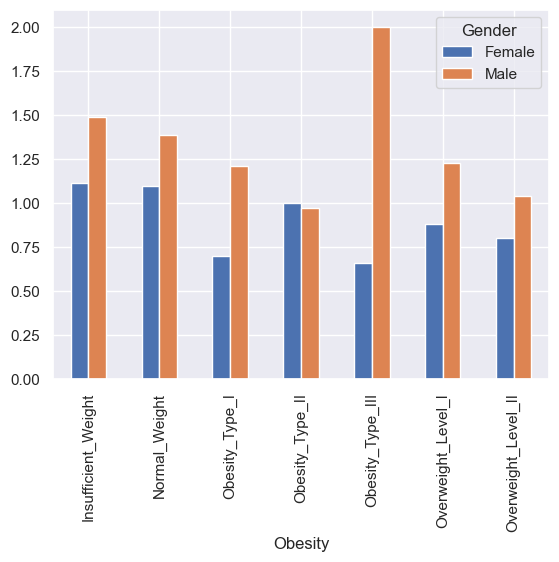

In [30]:
# FAF is the frequency of days per week that one often has physical activity
# Below is the pivot by gender and obesity level showcasing an average FAF score
fcvc = data.pivot_table(index='Obesity', columns='Gender', values='FAF', aggfunc='mean')
fcvc.plot.bar()

# Looks like regardless of obesity level, men tend to be more physically active

In [31]:
le = LabelEncoder() # creating a LabelEncoder class instance to replace categorical attributes
for col in categorical:
    data[col] = le.fit_transform(data[col])
    
data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6


In [33]:
# Outliers
def check_outliers(d):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (d < lower_bound) | (d > upper_bound)

outliers = pd.DataFrame()
for col in data.columns:
    outliers[col] = check_outliers(data[col])

outliers

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2107,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2108,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2109,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


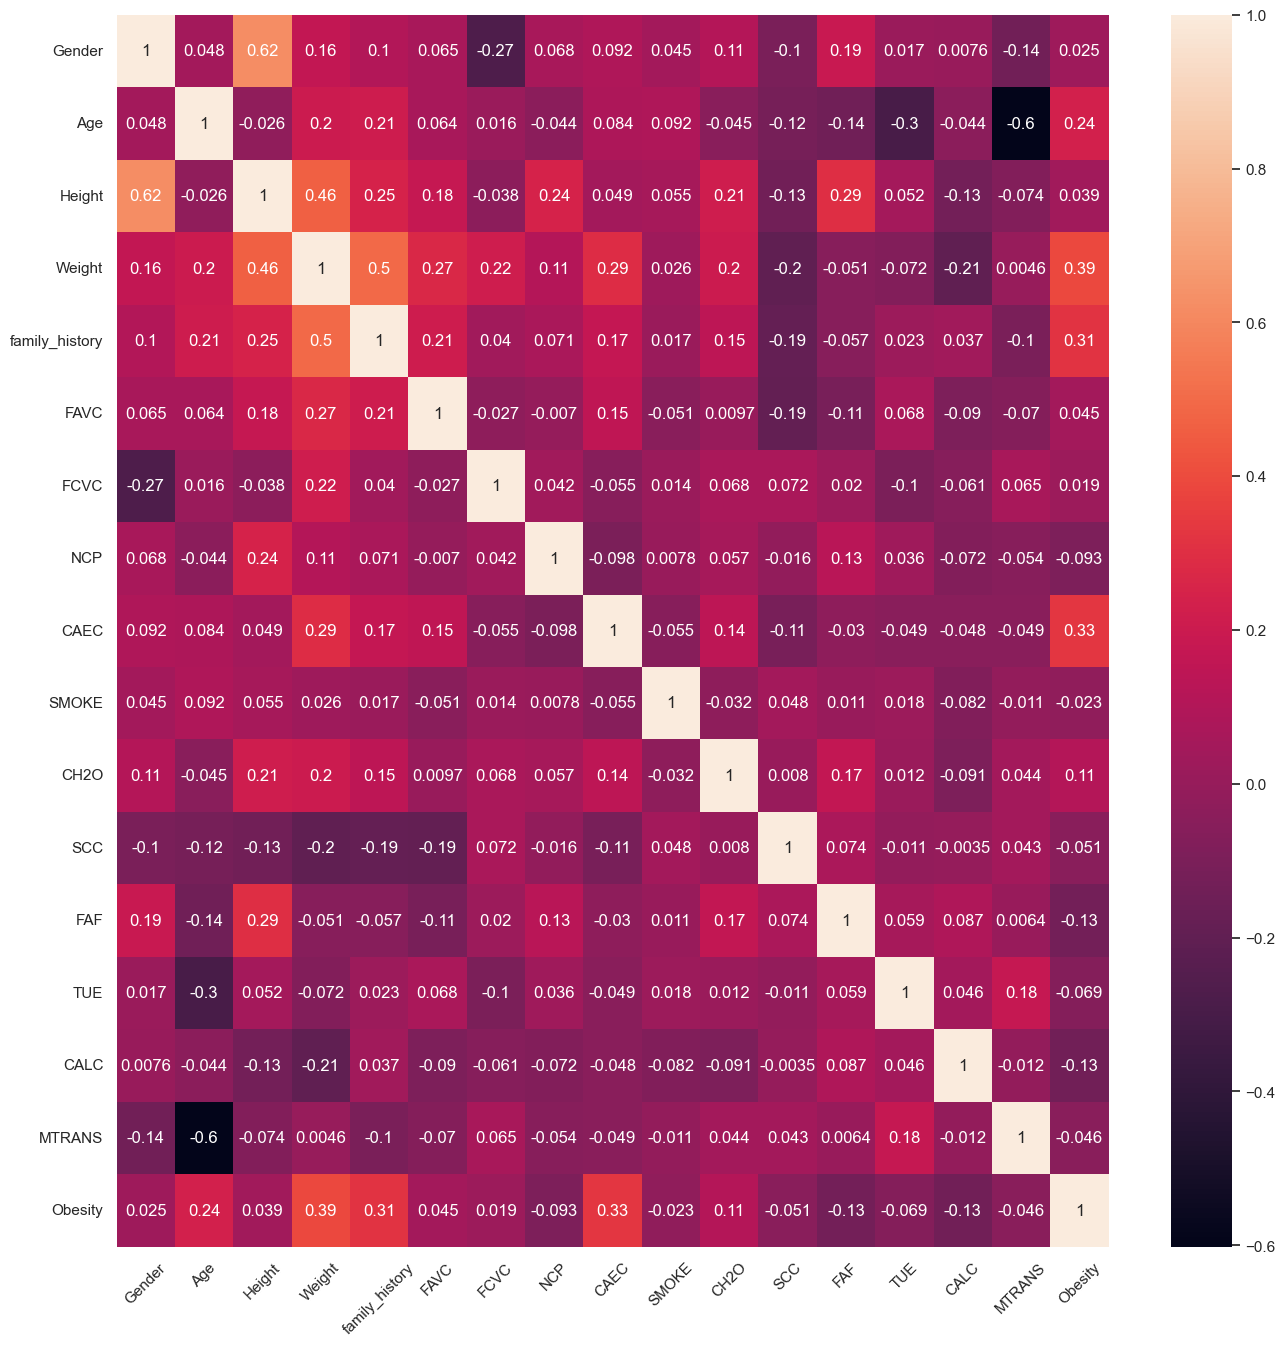

In [41]:
# Correlation heatmap
plt.figure(figsize=(16,16))
data_corr = data.corr()
sns.heatmap(data_corr, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

## ML Model

In [56]:
# Splitting into a train-test split
X = data.iloc[:, :-1] # independent variables = all except for obesity
y = data.iloc[:, -1] # dependent variable = obesity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [44]:
sc = StandardScaler() # creating a StandardScaler() class instance to scale the data for the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [49]:
# Deploying the model
xgbr = XGBRegressor()
param_grid = {'n_estimators': [40,80,120,160,200], 'max_depth': [2,3,4,5], 'max_features': [0.1,0.2,0.3,0.4,0.5]}
gscv = GridSearchCV(xgbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
gscv.fit(X_train, y_train)
print("Best parameters :", gscv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters : {'max_depth': 5, 'max_features': 0.1, 'n_estimators': 200}


In [50]:
# Setting XGB Regressor with best parameters
xgbr = XGBRegressor(n_estimators=200, max_depht=5, max_features=0.1)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depht=5, max_depth=None, max_features=0.1,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, ...)

In [61]:
y_xgbr = xgbr.predict(X_test).round()
print(y_xgbr)
print('Mean Absolute Error: ', mean_absolute_error(y_xgbr, y_test))

[4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 3. 4. 3. 4. 4. 4. 3. 4. 4. 3. 4.
 4. 3. 4. 3. 4. 3. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 4. 4. 3. 4.
 4. 4. 4. 4. 4. 4. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 3. 4. 3. 4. 4. 4. 4. 4. 4. 3. 4. 4. 3. 4. 4. 4. 4. 3. 3. 3. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 3. 3. 4.
 3. 4. 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4.
 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 3. 4.
 4. 4. 4. 3. 4. 3. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 3.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4.
 3. 4. 4. 4. 3. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4.
 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 3. 4. 4. 4. 4. 3. 4. 4. 4.
 4. 4. 4. 4. 4. 3. 3. 3. 4. 3. 4. 4. 4. 4. 4. 4. 4.